# Image reconstruction in X-ray tomography

Pierre Boyeau - MVA

\begin{align*}
    y = H \overline{x} + w, w \sim \mathcal{N}(0, \sigma^2 I_M)
\end{align*}

\begin{align*}
    \min_{x} f(x) := \frac{1}{2} ||x-y||^2 + \lambda r(x)
\end{align*}

The objective of this TP will be to compare the performance of several algorithms (notably in terms of speed).

We will study:

-  Gradient descend: $x_{n+1} = x_n + \gamma \nabla f(x_n)$
-  MM with $h(x, x_0) = f(x_0) + <\nabla f(x_0), x - x_0> + \frac{1}{2} ||x - x_0||_{A(x_0)}$ which leads to the following update:

\begin{align*}
    x_{x+1} = x_n - A^{-1}(x_n) \nabla f(x_n)
\end{align*}

Never compute $H^TH$

Think about numerical efficiency

In [1]:
from scipy.sparse.linalg import svds, bicg, LinearOperator
from scipy.sparse import diags
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

SIGMA = 1.0

h = loadmat('data/H.mat')['H']
x = loadmat('data/x.mat')['x']
g = loadmat('data/G.mat')['G']

y = h.dot(x) + (SIGMA*np.random.randn(16200, 1))
y = y.reshape(-1)

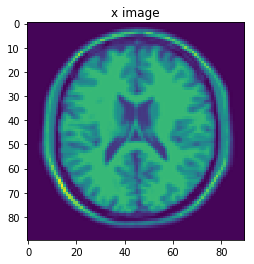

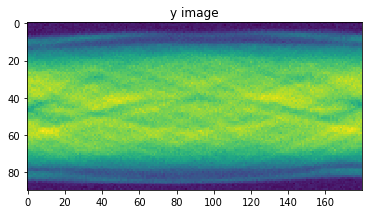

In [2]:
N = 90*90
M = 90*180

plt.imshow(x.reshape((90, 90), order='F'))
plt.title('x image')
plt.show()

plt.imshow(y.reshape((90, 180), order='F'))
plt.title('y image')
plt.show()

## 2. Optimization problem

In [5]:
lamb, delta = 0.13, 2e-2

def f(my_x):
    first_vec = h.dot(my_x) - y
    first_vec = first_vec **2
    assert first_vec.shape == (16200,), first_vec.shape
    first_scal = 0.5 * first_vec.sum()
    
    g_x = g.dot(my_x)
    assert g_x.shape == (16200,)
    second_vec = np.sqrt(1.0 + (g_x**2) / (delta**2))
    second_scal = lamb * second_vec.sum()
    
    res = first_scal - second_scal
    return res

\begin{align*}
    f(x) := \frac{1}{2} ||Hx-y||^2 + \lambda r(x)
\end{align*}
where 
\begin{align*}
    r(x) = \sum_{n=1}^{2N} \psi ([Gx]_n)
\end{align*}

Notice that:
\begin{align*}
    \frac{\partial r(x)}{\partial x_k} = \sum_n \dot{\psi}([Gx]_n)G_{nk}
\end{align*}

Hence $\nabla r = G^T \times \dot{\Psi} $, where $\dot{\Psi}=(\dot\psi ([Gx]_n))_n $. 

We get that:

\begin{align*}
    \nabla f(x) := H^T(Hx-y) + \lambda G^T \times \dot{\Psi}
\end{align*}

We define $\phi: u \mapsto \sqrt{1 + u^2/\delta^2}$, so that:
\begin{align*}
    \dot \phi(u) = \frac{u}{\delta \sqrt{u^2 + \delta^2}}
\end{align*}

It follows easily that $r$ is $1/\delta^2$-Lipschitz 

Let's show that $f$ has a Lipschitz-gradient:

\begin{align*}
    \forall (x, z) \in \mathbb{R}^N \times \mathbb{R}^N, \nabla f(x) - \nabla f(z) = H^TH(x - z) + G^T \times (\dot \Psi_x - \dot \Psi_z)
\end{align*}

Hence:
\begin{align*}
    ||\nabla f(x) - \nabla f(z)|| &\leq ||H^TH||_{spec} ||x - z|| + ||G|| \times ||\dot \Psi_x - \dot \Psi_z|| \\
    &\leq ||H||^2 ||x - z|| + ||G|| \times 1/\delta^2\times ||G|| \times ||x-z|| \\
    &\leq [||H||^2 + \lambda/\delta^2 ||G||^2] \times ||x-z||
\end{align*}


In [6]:
def sparse_norm(sparse_mat):
    _, eigvals, _ = svds(sparse_mat)
    return np.abs(eigvals).max()

norm_h = sparse_norm(h)
norm_g = sparse_norm(g)
lip_cst = norm_h**2 + lamb/(delta*delta) * (norm_g**2)
print(lip_cst)

18092.773276864787


## Optimization algorithms

In [7]:
x0 = np.zeros(N)

### 1. Gradient Descent Algorithm

We need to be careful how we compute the gradient of $f$, as the computation can very easily become intractable

In [8]:
def single_plot(stats, label=None):
    times, vals = stats
    plt.plot(times, vals, label=label)
    plt.xscale('log')
    plt.xlabel('Normalized Time Scale')
    plt.ylabel('Loss')

In [9]:
# h_transpose_h = h.T.dot(h)

def grad_f(my_x):
    first_prod = h.dot(my_x) - y
    first_term = h.T.dot(first_prod)
    
    gx = g.dot(my_x)
    dot_phi = gx / (delta * np.sqrt(gx ** 2 + delta ** 2))

    grad = first_term + lamb * g.T.dot(dot_phi)
    return grad

Method has converged


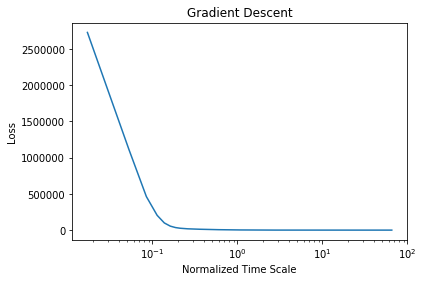

In [10]:
from gradient_descent import GradientDescent

gd = GradientDescent(f=f, nu=lip_cst, grad_f=grad_f, 
                     x_dim=N, max_iter=5000)
x_gd, gd_stats = gd.optimize(x0)
single_plot(gd_stats)
_ = plt.title('Gradient Descent')

### 2. MM quadratic algorithm

Recall that:
    
\begin{align*}
    \nabla f(x) := H^T(Hx-y) + \lambda G^T \times \dot{\Psi}
\end{align*}

From this expression, it is clear that $f$ is twice differentiable in $\mathbb{R}^N$. To obtain a quadratic majorant of it, let's compute its Hessian

\begin{align*}
    \nabla^2 f(x) = H^T \times H + \lambda G^T \nabla \dot \Psi
\end{align*}

Let's explicit this second quantity as:

\begin{align*}
    \frac{\partial}{\partial x_k \partial x_l}r(x) 
    = \sum_n \ddot \Psi([Gx]_n) G_{nl} G_{nk}
\end{align*}

Which gives that $\nabla^2 r = G^T diag \ddot \Psi \times G$
where

\begin{align*}
    \ddot \Psi: u \mapsto \frac{1}{\sqrt{\frac{\delta^{2} + u^{2}}{\delta^{2}}} \left(\delta^{2} + u^{2}\right)}
\end{align*}

The Hessian of f is defined as $H^TH + \lambda G^T diag \ddot \Psi \times G$ which obviously is positive semi definite if you notice that $\ddot \Psi \geq 0$

Based on the course, a natural quadratic majorant is:

\begin{align*}
    A(x) = H^T H  + \lambda G^T diag(\dot \Phi([Gx]_i) / [Gx]_i) G
\end{align*}

Method has converged


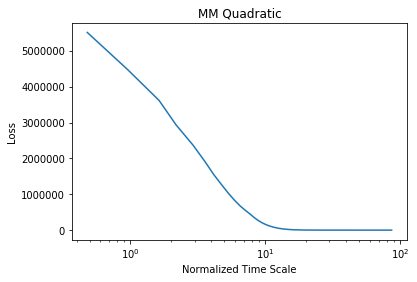

In [11]:
def a_major_func(my_v, my_x):
    hess_v = h.T.dot(h.dot(my_v))
    gx = g.dot(my_x)
    
    # Basically corresponds to Phi'(Gx) / Gx
    diag_term = 1.0 / (delta * np.sqrt(gx ** 2 + delta ** 2))
    mat_diag_term = diags(diag_term)
    gv = g.dot(my_v)
    right_term = g.T.dot(mat_diag_term.dot(gv))
    return hess_v + lamb * right_term 
     

from mm_quadratic import MMQuadratic

mm = MMQuadratic(f=f, qmajor=a_major_func, grad_f=grad_f, theta=1.9,
                 max_iter=500)
x_mm, stats_mm = mm.optimize(x0)
single_plot(stats_mm)
_ = plt.title('MM Quadratic')

### 3. 3MG algorithm

Method has converged


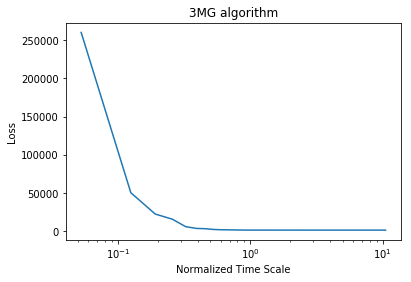

In [15]:
from three_mg import ThreeMG

mg = ThreeMG(f=f, my_h=h, my_g=g, my_delta=delta, my_lambda=lamb,
             grad_f=grad_f, max_iter=500)
x_mg, stats_mg = mg.optimize(x0=x0)
single_plot(stats_mg)
plt.title('3MG algorithm')
plt.show()

### 4. Block MM Quadratic algorithm

In such case, $A_j$ will correspond to:

\begin{align*}
    A_j = H_j^T H_j + \lambda G_j ^T diag \ddot \Psi \times G_j
\end{align*}

In [13]:
def get_aj(my_x, block_indices):
    x_j = my_x[block_indices].copy()
    g_j = g[:, block_indices]
    h_j = h[:, block_indices]
    g_x = g.dot(my_x)

    def a_j_func(vect):
        hess_v = h_j.T.dot(h_j.dot(vect))

        diag_term = 1.0 / (delta * np.sqrt(g_x ** 2 + delta ** 2))
        mat_diag_term = diags(diag_term)
        gv = g_j.dot(vect)
        right_term = g_j.T.dot(mat_diag_term.dot(gv))

        return hess_v + lamb * right_term

    return a_j_func

Text(0.5,1,'K influence for Block MM Optimization')

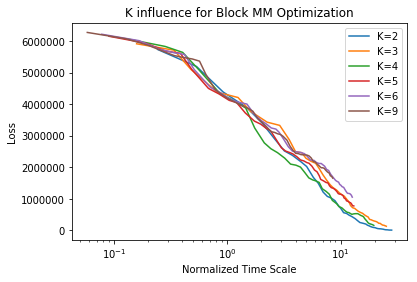

In [14]:
from bloc_mm_quadratic import BlockMM

for factor in [2, 3, 4, 5, 6, 9]:
    n_j = N // factor
    b_mm = BlockMM(f=f, n_j=n_j, grad_f=grad_f,
                   get_aj=get_aj, n=N, max_iter=50)
    x_bmm, stats_bmm = b_mm.optimize(x0)
    single_plot(stats_bmm, label='K={}'.format(factor))
plt.legend()
plt.title('K influence for Block MM Optimization')

Even if every choice of K (except $K=1$ which simply corresponds to a regular Quadratic MM and thus has no interest) seem acceptable, we choose from now on:

\begin{align*}
    K=4
\end{align*}

In [23]:
b_mm = BlockMM(f=f, n_j=N//2, grad_f=grad_f,
               get_aj=get_aj, n=N, max_iter=500)
x_bmm, stats_bmm = b_mm.optimize(x0)

Method has converged


### Comparison of the methods

All experiments launched above already compute the criterion estimate with respect to time. This task is perform in my code in the `f_eval` method common to all algorithms, and that you can find in `optim_mdl.py`

In addition, all algorithms had the following stopping criterion:

\begin{align*}
    ||\nabla f(x_n)|| \leq \sqrt{N} 10^{-4}
\end{align*}

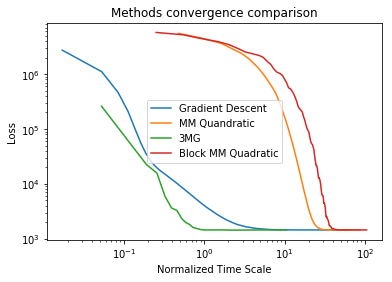

In [24]:
single_plot(gd_stats, label='Gradient Descent')
single_plot(stats_mm, label='MM Quandratic')
single_plot(stats_mg, label='3MG')
single_plot(stats_bmm, label='Block MM Quadratic')
plt.title('Methods convergence comparison')
plt.legend()
plt.yscale('log')
plt.show()

In [25]:
all_names = ['Gradient Descent', 'MM Quadratic', 
             '3MG', 'Block MM Quadratic']
all_stats = [gd_stats, stats_mm, stats_mg, stats_bmm]
for (names, stats) in zip(all_names, all_stats):
    times = stats[0]
    print('{} Time for Convergence: {}'.format(names, times[-1]))

Gradient Descent Time for Convergence: 65.48322367668152
MM Quadratic Time for Convergence: 86.8966896533966
3MG Time for Convergence: 10.514466762542725
Block MM Quadratic Time for Convergence: 104.54171466827393


Based on all these observations, **3MG** is without context the fastest method.

The second fastest method, classical gradient descent is **6 times** slower than 3MG ...

One can note that the Block MM Quadratic Method is far from being great.

Let's now tune $\lambda, \mu$ in order to obtain the best Signal To Noise Ratio

In [26]:
def snr(x_gt, x_restored):
    my_x_gt = x_gt.reshape(-1)
    my_x_rest = x_restored.reshape(-1)
    norm_gt = (my_x_gt ** 2).sum()
    norm_diff = ((my_x_gt - my_x_rest) ** 2).sum()
    return 10.0 * (np.log10(norm_gt) - np.log10(norm_diff))

In [27]:
# Let's compute the baseline SNR 
# - The one we got using default parameters

snr(x, x_mg)

18.805353759480536

We will need these 2 functors, not for direct optimization but to simply monitor convergence in the algorithm

In [28]:
def construct_f(my_lamb, my_delt):
    def my_f(my_x):
        first_vec = h.dot(my_x) - y
        first_vec = first_vec ** 2
        assert first_vec.shape == (16200,), first_vec.shape
        first_scal = 0.5 * first_vec.sum()

        g_x = g.dot(my_x)
        assert g_x.shape == (16200,)
        second_vec = np.sqrt(1.0 + (g_x ** 2) / (my_delt ** 2))
        second_scal = my_lamb * second_vec.sum()

        res = first_scal - second_scal
        return res

    return my_f


def construct_grad_f(my_lamb, my_delt):
    def my_grad_f(my_x):
        first_prod = h.dot(my_x) - y
        first_term = h.T.dot(first_prod)

        gx = g.dot(my_x)
        dot_phi = gx / (my_delt * np.sqrt(gx ** 2 + my_delt ** 2))

        grad = first_term + my_lamb * g.T.dot(dot_phi)
        return grad
    return my_grad_f

In [31]:
# Params subspace to search over

from sklearn.model_selection import ParameterGrid
params_grid = {
    'lambda': np.geomspace(1e-3, 1e0, 10),
    'delta': np.geomspace(1e-3, 1e-1, 10)
}
params = ParameterGrid(params_grid)
params = list(params)
params = [(param['lambda'], param['delta']) for param in params]

In [38]:
# Grid search task
from tqdm import tqdm_notebook
def parameters_search(x_init, my_params):
    scores = []
    for lamb_cand, delta_cand in tqdm_notebook(my_params):
        new_f = construct_f(my_lamb=lamb_cand, my_delt=delta_cand)
        new_grad_f = construct_grad_f(my_lamb=lamb_cand, my_delt=delta_cand)

        mg = ThreeMG(f=new_f, my_h=h, my_g=g, my_delta=delta_cand, my_lambda=lamb_cand,
                     grad_f=new_grad_f, max_iter=500)
        x_mg, _ = mg.optimize(x0=x_init)
        scores.append(snr(x, x_mg))

    best_idx = np.argmax(scores)
    best_params = my_params[best_idx]
    best_score = scores[best_idx]

    return best_params, best_score

In [39]:
# We use obtained x as starting point, which is probably
# More interesting than x_0
x0_new = x_mg.copy()
best_params, best_snr = parameters_search(x_init=x0_new, 
                                          my_params=params)

Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has converged
Method has co

In [40]:
print(best_snr)

19.393589572750255


In [41]:
print(best_params)

(1.0, 0.1)


Grid Search allows to obtain **sligthly better results in terms of SNR**. Due to lack of time I did not try to expand the grid, as I see that the optimal parameters are obtained for:

\begin{align*}
    \lambda = 1, \delta=0.1
\end{align*}

i.e. extremal points in the grid.
